In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
#print(os.listdir("/content/drive"))

In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column].tolist())
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [0]:
%%time
train = load_df('../My Drive/train.csv')
test = load_df('../My Drive/test.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
train date: 20160801 to 20170801
test date: 20170802 to 20180430
CPU times: user 2min 46s, sys: 14.4 s, total: 3min 1s
Wall time: 3min 17s


In [0]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [0]:
# only train feature
for c in train.columns.values:
    if c not in test.columns.values: print(c)

totals.transactionRevenue
trafficSource.campaignCode


In [0]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'].astype(float))
print(train['totals.transactionRevenue'].describe())

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: totals.transactionRevenue, dtype: float64


In [0]:
all_data = train.append(test).reset_index(drop=True) #, sort = False
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 55 columns):
channelGrouping                                      object
date                                                 int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                      bool
device.language                                      object
device.mobileDeviceBranding                          object
device.mobileDeviceInfo                              object
device.mobileDeviceMarketingName                     object
device.mobileDeviceModel                             object
device.mobileInputSelector                           object
device.operatingSystem                            

In [0]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                                   100
totals.newVisits                                200593
totals.bounces                                  453023
trafficSource.keyword                           502929
trafficSource.referralPath                      572712
trafficSource.isTrueDirect                      629648
trafficSource.adwordsClickInfo.gclId            882092
trafficSource.adwordsClickInfo.adNetworkType    882193
trafficSource.adwordsClickInfo.isVideoAd        882193
trafficSource.adwordsClickInfo.page             882193
trafficSource.adwordsClickInfo.slot             882193
trafficSource.adContent                         892707
trafficSource.campaignCode                      903652
dtype: int64


In [0]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adwordsClickInfo.gclId',
            'trafficSource.adwordsClickInfo.adNetworkType',
            'trafficSource.adwordsClickInfo.isVideoAd',
            'trafficSource.adwordsClickInfo.page',
            'trafficSource.adwordsClickInfo.slot',
            'trafficSource.adContent']:
    all_data[col].fillna('unknown', inplace=True)

# fillna numeric feature
all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int)

# fillna boolean feature
all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [0]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
#for c in constant_column:
#    print(c + ':', train[c].unique())

print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'socialEngagementType', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.campaignCode']


In [0]:
# pickup any visitor
all_data[all_data['fullVisitorId'] == '7813149961404844386'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews']].head(20)

,date,visitId,visitNumber,totals.hits,totals.pageviews
174824,20161117,1479408977,1,37,33
20708,20161118,1479496350,2,2,2
21246,20161118,1479507825,3,14,12
191751,20161122,1479831970,4,3,3
191883,20161122,1479842287,5,4,4
294426,20161202,1480691778,13,1,1
655608,20161206,1481036817,14,12,10
656641,20161206,1481040342,15,1,1
655799,20161206,1481061263,16,28,19
655801,20161206,1481065071,17,28,26


In [0]:
train_rev = all_data[all_data['totals.transactionRevenue'] > 0].copy()
print(len(train_rev))
train_rev.head()

11515


,channelGrouping,date,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,fullVisitorId,geoNetwork.city,geoNetwork.continent,geoNetwork.country,...,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitId,visitNumber,visitStartTime
752,Direct,20160902,Chrome,desktop,False,Linux,6194193421514403509,Ann Arbor,Americas,United States,...,unknown,(not set),True,unknown,(none),unknown,(direct),1472843572,1,1472843572
753,Organic Search,20160902,Chrome,desktop,False,Macintosh,5327166854580374902,New York,Americas,United States,...,unknown,(not set),True,(not provided),organic,unknown,google,1472844906,3,1472844906
799,Referral,20160902,Chrome,desktop,False,Linux,8885051388942907862,New York,Americas,United States,...,unknown,(not set),True,unknown,referral,/,mall.googleplex.com,1472827393,7,1472827393
802,Referral,20160902,Chrome,desktop,False,Windows,0185467632009737931,Mountain View,Americas,United States,...,unknown,(not set),True,unknown,referral,/,mall.googleplex.com,1472846398,6,1472846398
859,Referral,20160902,Chrome,desktop,False,Macintosh,3244885836845029978,not available in demo dataset,Americas,United States,...,unknown,(not set),True,unknown,referral,/,mall.googleplex.com,1472824817,4,1472824817


In [0]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.sort_values('Revenue').plot.barh()

In [0]:
format_str = '%Y%m%d'
all_data['formated_date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_year'] = all_data['formated_date'].apply(lambda x:x.year)
all_data['_month'] = all_data['formated_date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['formated_date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['formated_date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['formated_date'].apply(lambda x:x.weekday())
# remember these features were equal, but not always? May be it means something...
all_data["_id_incoherence"] = pd.to_datetime(all_data['visitId'], unit='s') != all_data['formated_date']

all_data.drop(['date','formated_date'], axis=1, inplace=True)

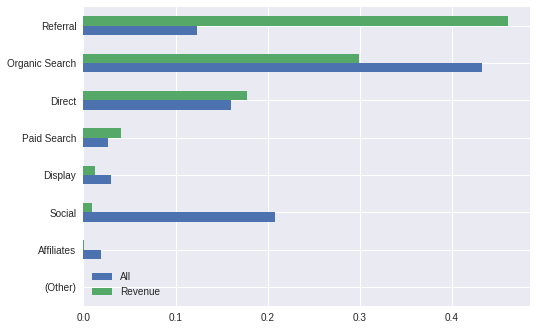

In [0]:
plotCategoryRateBar(all_data, train_rev, 'channelGrouping')

In [0]:
print('train all:', len(train))
print('train unique fullVisitorId:', train['fullVisitorId'].nunique())
print('train unique visitId:', train['visitId'].nunique())
print('-' * 30)
print('test all:', len(test))
print('test unique fullVisitorId:', test['fullVisitorId'].nunique())
print('test unique visitId:', test['visitId'].nunique())

#print('common fullVisitorId:', len(pd.merge(train, test, how='inner', on='fullVisitorId'))) # 183434

train all: 903653
train unique fullVisitorId: 714167
train unique visitId: 886303
------------------------------
test all: 804684
test unique fullVisitorId: 617242
test unique visitId: 779504


In [0]:
print(all_data['visitNumber'].value_counts()[:5])
print('-' * 30)
print(all_data['totals.newVisits'].value_counts())
print('-' * 30)
print(all_data['totals.bounces'].value_counts())

1    1307430
2     182542
3      70962
4      37886
5      23314
Name: visitNumber, dtype: int64
------------------------------
1    1307430
0     400907
Name: totals.newVisits, dtype: int64
------------------------------
1    871578
0    836759
Name: totals.bounces, dtype: int64


In [0]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

In [0]:
print('train all sessionId:', len(train['sessionId']))
print('train unique sessionId:', train['sessionId'].nunique())

train all sessionId: 903653
train unique sessionId: 902755


unique browser count: 54


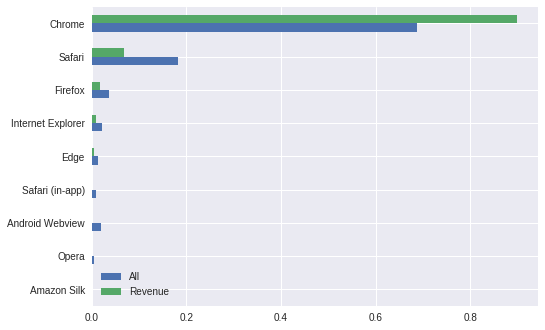

In [0]:
print('unique browser count:', train['device.browser'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.browser', 10)

In [0]:
pd.crosstab(all_data['device.deviceCategory'], all_data['device.isMobile'], margins=False)

device.isMobile,False,True
device.deviceCategory,,
desktop,1171330,249
mobile,317,471019
tablet,23,65399


In [0]:
all_data['isMobile'] = True
all_data.loc[all_data['device.deviceCategory'] == 'desktop', 'isMobile'] = False

unique operatingSystem count: 20


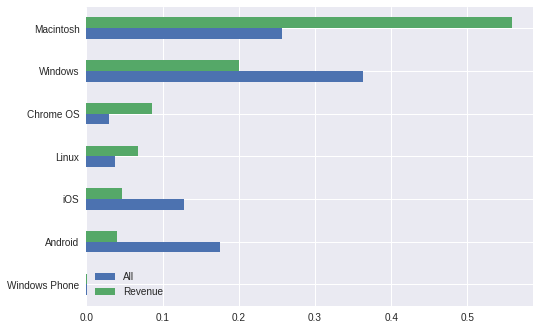

In [0]:
print('unique operatingSystem count:', train['device.operatingSystem'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.operatingSystem', 10)

unique geoNetwork.city count: 649


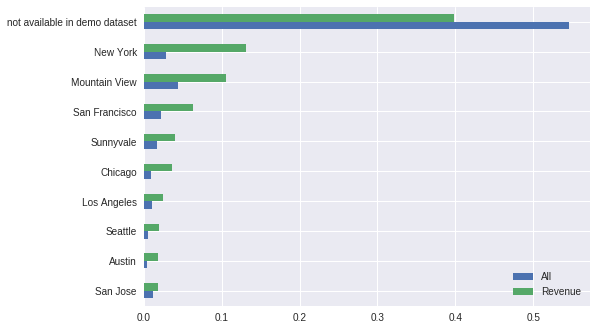

In [0]:
print('unique geoNetwork.city count:', train['geoNetwork.city'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.city', 10)

unique geoNetwork.region count: 376


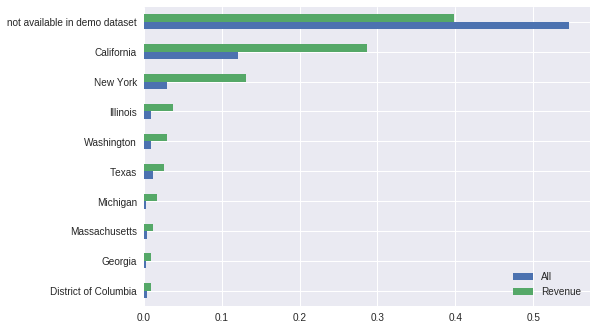

In [0]:
print('unique geoNetwork.region count:', train['geoNetwork.region'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.region', 10)

unique geoNetwork.subContinent count: 23


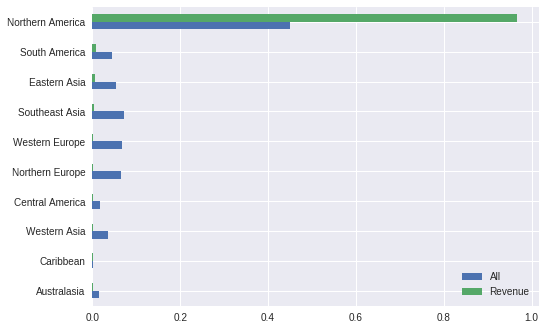

In [0]:
print('unique geoNetwork.subContinent count:', train['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.subContinent', 10)

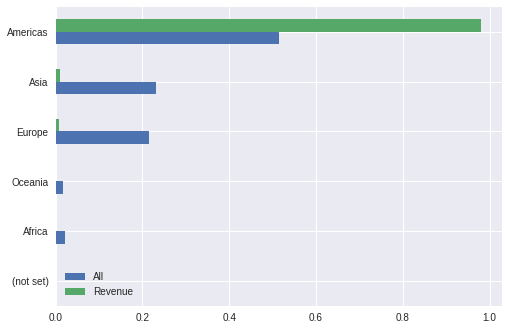

In [0]:
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.continent')

unique geoNetwork.metro count: 94


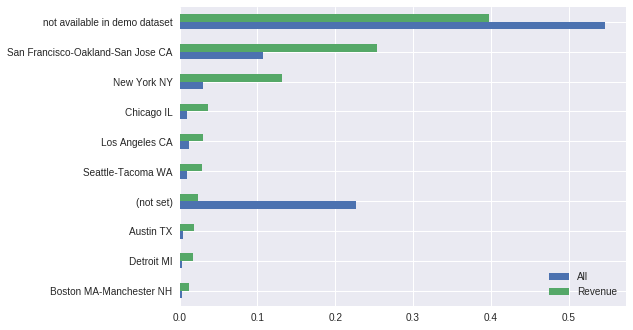

In [0]:
print('unique geoNetwork.metro count:', train['geoNetwork.metro'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.metro', 10)

unique geoNetwork.networkDomain count: 28064


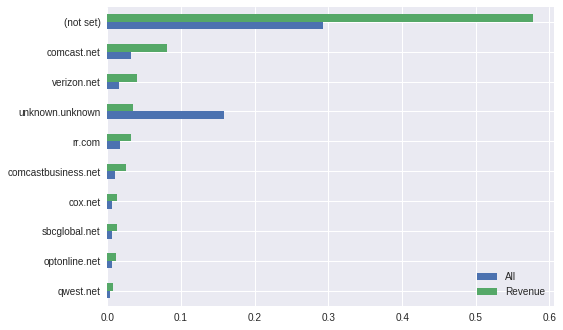

In [0]:
print('unique geoNetwork.networkDomain count:', train['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.networkDomain', 10)

In [0]:
print(all_data['totals.hits'].value_counts()[:10])

all_data['totals.hits'] = all_data['totals.hits'].astype(int)

1     864064
2     237499
3     134435
4      80875
5      63687
6      46598
7      38137
8      29717
9      24999
10     20306
Name: totals.hits, dtype: int64


In [0]:
print(all_data['totals.pageviews'].value_counts()[:10])

all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)

1     876567
2     249794
3     142896
4      86666
5      64712
6      47721
7      37751
8      29586
9      24153
10     19228
Name: totals.pageviews, dtype: int64


unique trafficSource.adContent count: 44


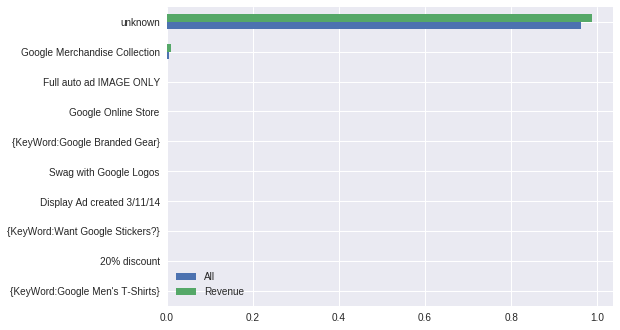

In [0]:
print('unique trafficSource.adContent count:', train['trafficSource.adContent'].nunique())

plotCategoryRateBar(all_data, train_rev, 'trafficSource.adContent', 10)

all_data['_adContentGMC'] = (all_data['trafficSource.adContent'] == 'Google Merchandise Collection').astype(np.uint8)

unique trafficSource.campaign count: 10


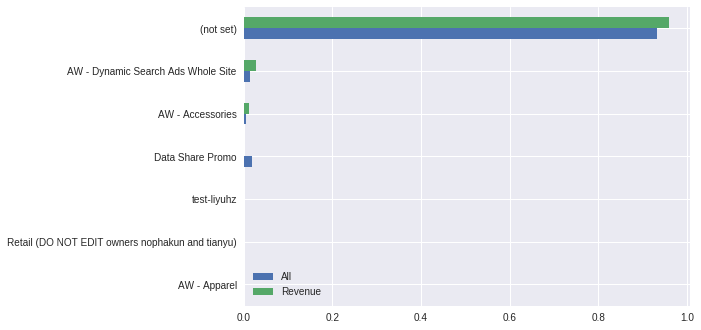

In [0]:
print('unique trafficSource.campaign count:', train['trafficSource.campaign'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.campaign', 10)

all_data['_withCampaign'] = (all_data['trafficSource.campaign'] != '(not set)').astype(np.uint8)

False    1173819
True      534518
Name: trafficSource.isTrueDirect, dtype: int64


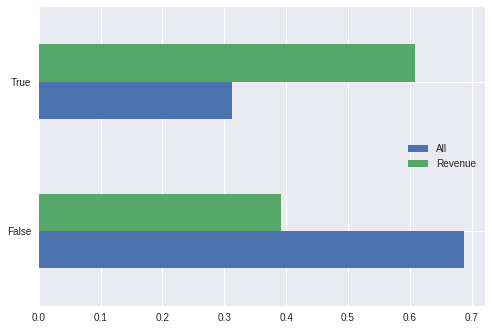

In [0]:
print(all_data['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.isTrueDirect')

unique trafficSource.keyword count: 3659


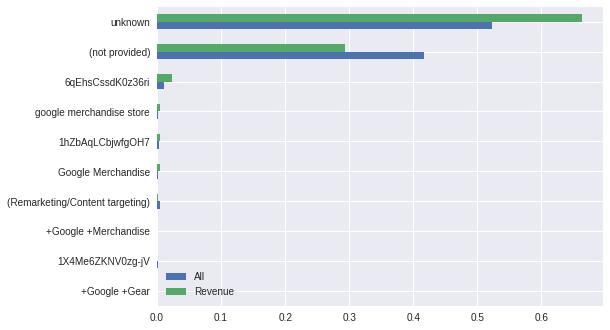

In [0]:
print('unique trafficSource.keyword count:', train['trafficSource.keyword'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.keyword', 10)

unique trafficSource.medium count: 7


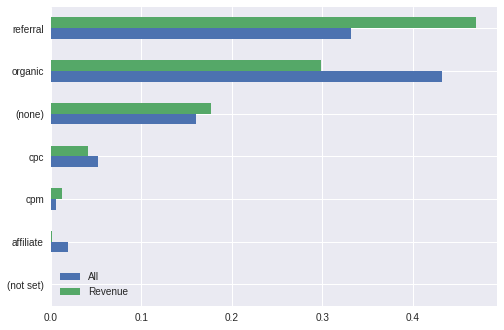

In [0]:
print('unique trafficSource.medium count:', train['trafficSource.medium'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.medium')

unique trafficSource.referralPath count: 1475


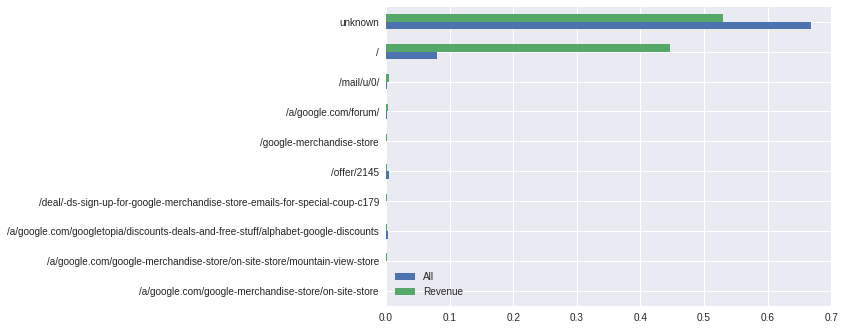

In [0]:
print('unique trafficSource.referralPath count:', train['trafficSource.referralPath'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.referralPath', 10)

all_data['_referralRoot'] = (all_data['trafficSource.referralPath'] == '/').astype(np.uint8)

unique trafficSource.source count: 380


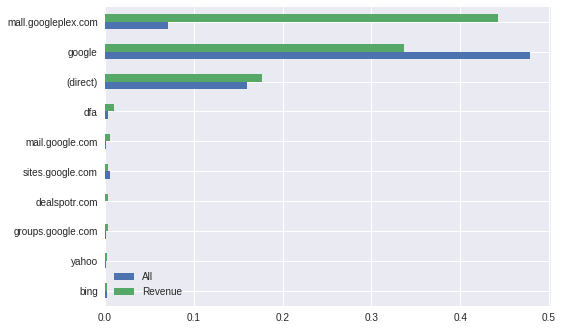

In [0]:
print('unique trafficSource.source count:', train['trafficSource.source'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.source', 10)

all_data['_sourceGpmall'] = (all_data['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)

In [0]:
_='''
'''
all_data['_meanHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('mean')
all_data['_meanHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('mean')
all_data['_meanHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('mean')
all_data['_sumHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('sum')
all_data['_sumHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('sum')
all_data['_sumHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = all_data.groupby('fullVisitorId')[feature].mean()
    all_data['_usermean_' + feature] = all_data.fullVisitorId.map(info)
    
for feature in ['visitNumber']:
    info = all_data.groupby('fullVisitorId')[feature].max()
    all_data['_usermax_' + feature] = all_data.fullVisitorId.map(info)

In [0]:
# remember visitId dublicates?
all_data['_visitId_dublicates'] = all_data['visitId'].map(all_data['visitId'].value_counts())
# remember session dublicates?
all_data['_session_dublicates'] = all_data['sessionId'].map(all_data['sessionId'].value_counts())

In [0]:
all_data['_source.country'] = all_data['trafficSource.source'] + '_' + all_data['geoNetwork.country']
all_data['_campaign.medium'] = all_data['trafficSource.campaign'] + '_' + all_data['trafficSource.medium']
all_data['_browser.category'] = all_data['device.browser'] + '_' + all_data['device.deviceCategory']
all_data['_browser.os'] = all_data['device.browser'] + '_' + all_data['device.operatingSystem']


In [0]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.transactionRevenue    804684
dtype: int64


In [0]:
all_data.drop([
    'sessionId','visitId','visitStartTime',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot'],axis=1,inplace=True)

for i, t in all_data.loc[:, all_data.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        all_data[i].fillna('unknown', inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')

In [0]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 54 columns):
channelGrouping                             int64
device.browser                              int64
device.deviceCategory                       int64
device.isMobile                             bool
device.operatingSystem                      int64
fullVisitorId                               object
geoNetwork.city                             int64
geoNetwork.continent                        int64
geoNetwork.country                          int64
geoNetwork.metro                            int64
geoNetwork.networkDomain                    int64
geoNetwork.region                           int64
geoNetwork.subContinent                     int64
totals.bounces                              int64
totals.hits                                 int64
totals.newVisits                            int64
totals.pageviews                            int64
totals.transactionRevenue            

In [0]:
train = all_data[all_data['totals.transactionRevenue'].notnull()]
test = all_data[all_data['totals.transactionRevenue'].isnull()].drop(['totals.transactionRevenue'], axis=1)

In [0]:
train_id = train['fullVisitorId']
test_id = test['fullVisitorId']

Y_train_reg = train.pop('totals.transactionRevenue')
#Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = train.drop(['fullVisitorId'], axis=1)
X_test  = test.drop(['fullVisitorId'], axis=1)

print(X_train.shape, X_test.shape)

(903653, 52) (804684, 52)


In [0]:
import sys
import gc

del all_data, train, test, train_rev
gc.collect()

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

          name       size
0      X_train  332544328
1       X_test  296123736
2         info  152975875
3     train_id   75797496
4      test_id   67496214
5  Y_train_reg   14458472
6           _6      18558
7     null_cnt      10594
8          _14      10166
9           __      10166


In [0]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
!pip install lightgbm
import lightgbm as lgb

    100% |████████████████████████████████| 1.2MB 8.8MB/s 


In [0]:
params={'learning_rate': 0.03,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.9,
        'feature_fraction': 0.9
       }

folds = GroupKFold(n_splits=5)

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train_reg, groups=train_id)):
    trn_x, trn_y = X_train.iloc[trn_], Y_train_reg.iloc[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train_reg.iloc[val_]
    
    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration_) / folds.n_splits

pred = sub_preds

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.60232
Early stopping, best iteration is:
[785]	valid_0's rmse: 1.59982
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.63196
Early stopping, best iteration is:
[727]	valid_0's rmse: 1.62888
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.58535
Early stopping, best iteration is:
[824]	valid_0's rmse: 1.5816
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.63956
Early stopping, best iteration is:
[602]	valid_0's rmse: 1.63812
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 1.61995
Early stopping, best iteration is:
[766]	valid_0's rmse: 1.61687


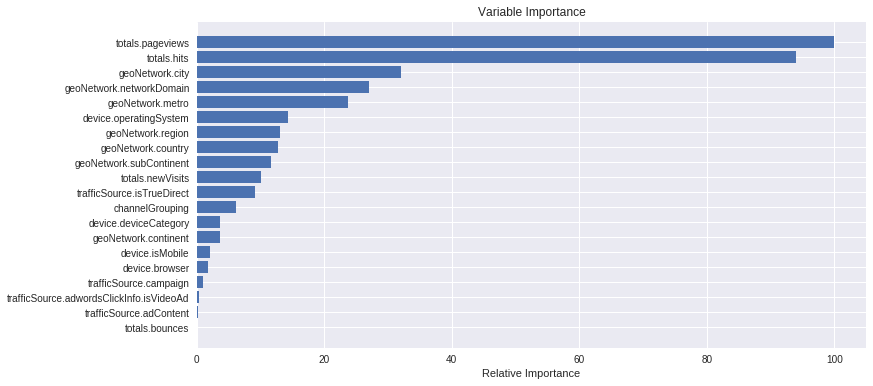

In [0]:
# Plot feature importance
feature_importance = reg.feature_importances_[:20]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [0]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("submission.csv", index=False)
submission_sum.head(20)

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.202222
1,0000049363351866189,0.005676
2,0000053049821714864,0.000000
3,0000059488412965267,0.007243
4,0000085840370633780,0.000113
5,0000091131414287111,0.000000
6,0000117255350596610,6.480830
7,0000118334805178127,0.000000
8,0000130646294093000,0.000000
9,0000150005271820273,0.000000


In [0]:
submission_sum['PredictedLogRevenue'].describe()

count    617242.000000
mean          0.157554
std           0.880736
min           0.000000
25%           0.000069
50%           0.000747
75%           0.002114
max          16.922312
Name: PredictedLogRevenue, dtype: float64